# PercePiano Dataset Exploration

This notebook explores the PercePiano dataset to understand:
1. The 19 perceptual dimensions and their meanings
2. Dataset structure and organization
3. Audio file formats and characteristics
4. Label distribution and patterns
5. Correlations between perceptual dimensions

**Goal**: Build deep understanding of the dataset as foundation for Phase 1 PercePiano recreation.

In [1]:
# Required imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display  # Added for spectrogram visualization
import soundfile as sf
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Dataset Structure Overview

In [2]:
# Dataset paths (updated after file reorganization)
base_path = Path('..')  # notebooks/ is one level down from project root
labels_path = base_path / 'results' / 'label_2round_mean_reg_19_with0_rm_highstd0.json'
audio_dir = base_path / 'PercePiano' / 'virtuoso' / 'data' / 'all_2rounds'
example_audio = base_path / 'examples' / 'Beethoven_WoO80_var27_8bars_3_15.wav'

print(f"Labels file exists: {labels_path.exists()}")
print(f"Audio directory exists: {audio_dir.exists()}")
print(f"Example audio exists: {example_audio.exists()}")

if audio_dir.exists():
    midi_files = list(audio_dir.glob('*.mid'))
    print(f"\nTotal MIDI files in dataset: {len(midi_files)}")
    print(f"First 5 files: {[f.name for f in midi_files[:5]]}")

Labels file exists: True
Audio directory exists: True
Example audio exists: True

Total MIDI files in dataset: 1202
First 5 files: ['Schubert_D960_mv2_8bars_10_08.mid', 'Schubert_D960_mv2_16bars_10_06.mid', 'Schubert_D935_no.3_4bars_9_21.mid', 'Beethoven_WoO80_thema_8bars_4_1.mid', 'Schubert_D960_mv3_16bars_2_19.mid']


## 2. Understanding the 19 Perceptual Dimensions

From the README and example data, the 19 dimensions are:

In [3]:
# Define the 19 perceptual dimensions based on the model comparison data
perceptual_dimensions = [
    "Timing_Stable_Unstable",
    "Articulation_Short_Long", 
    "Articulation_Soft_cushioned_Hard_solid",
    "Pedal_Sparse/dry_Saturated/wet",
    "Pedal_Clean_Blurred",
    "Timbre_Even_Colorful",
    "Timbre_Shallow_Rich",
    "Timbre_Bright_Dark",
    "Timbre_Soft_Loud",
    "Dynamic_Sophisticated/mellow_Raw/crude",
    "Dynamic_Little_dynamic_range_Large_dynamic_range",
    "Music_Making_Fast_paced_Slow_paced",
    "Music_Making_Flat_Spacious",
    "Music_Making_Disproportioned_Balanced",
    "Music_Making_Pure_Dramatic/expressive",
    "Emotion_&_Mood_Optimistic/pleasant_Dark",
    "Emotion_&_Mood_Low_Energy_High_Energy",
    "Emotion_&_Mood_Honest_Imaginative",
    "Interpretation_Unsatisfactory/doubtful_Convincing"
]

print(f"Total perceptual dimensions: {len(perceptual_dimensions)}")
print("\nPerceptual dimensions grouped by category:")

# Group by category
categories = {}
for dim in perceptual_dimensions:
    category = dim.split('_')[0]
    if category not in categories:
        categories[category] = []
    categories[category].append(dim)

for category, dims in categories.items():
    print(f"\n{category.upper()} ({len(dims)} dimensions):")
    for dim in dims:
        print(f"  - {dim}")

Total perceptual dimensions: 19

Perceptual dimensions grouped by category:

TIMING (1 dimensions):
  - Timing_Stable_Unstable

ARTICULATION (2 dimensions):
  - Articulation_Short_Long
  - Articulation_Soft_cushioned_Hard_solid

PEDAL (2 dimensions):
  - Pedal_Sparse/dry_Saturated/wet
  - Pedal_Clean_Blurred

TIMBRE (4 dimensions):
  - Timbre_Even_Colorful
  - Timbre_Shallow_Rich
  - Timbre_Bright_Dark
  - Timbre_Soft_Loud

DYNAMIC (2 dimensions):
  - Dynamic_Sophisticated/mellow_Raw/crude
  - Dynamic_Little_dynamic_range_Large_dynamic_range

MUSIC (4 dimensions):
  - Music_Making_Fast_paced_Slow_paced
  - Music_Making_Flat_Spacious
  - Music_Making_Disproportioned_Balanced
  - Music_Making_Pure_Dramatic/expressive

EMOTION (3 dimensions):
  - Emotion_&_Mood_Optimistic/pleasant_Dark
  - Emotion_&_Mood_Low_Energy_High_Energy
  - Emotion_&_Mood_Honest_Imaginative

INTERPRETATION (1 dimensions):
  - Interpretation_Unsatisfactory/doubtful_Convincing


## 3. Load and Explore Labels

In [4]:
# Load labels
with open(labels_path, 'r') as f:
    labels_data = json.load(f)

print(f"Total labeled performances: {len(labels_data)}")
print(f"First performance name: {list(labels_data.keys())[0]}")
print(f"First performance labels: {labels_data[list(labels_data.keys())[0]]}")
print(f"Label dimensions per performance: {len(labels_data[list(labels_data.keys())[0]])}")

Total labeled performances: 1202
First performance name: Schubert_D935_no.3_4bars_1_25
First performance labels: [0.5714285714285714, 0.7142857142857143, 0.5714285714285714, 0.7142857142857143, 0.6666666666666667, 0.5, 0.5952380952380952, 0.7619047619047619, 0.5, 0.5, 0.4523809523809524, 0.5714285714285714, 0.5, 0.6666666666666667, 0.5952380952380952, 0.7380952380952381, 0.4761904761904762, 0.619047619047619, 0.5, 0]
Label dimensions per performance: 20


In [5]:
# Convert to DataFrame for easier analysis
label_rows = []
for performance, ratings in labels_data.items():
    row = {'performance': performance}
    for i, rating in enumerate(ratings[:-1]):  # Last value seems to be player ID
        if i < len(perceptual_dimensions):
            row[perceptual_dimensions[i]] = rating
    row['player_id'] = ratings[-1]  # Last value is player ID
    label_rows.append(row)

df = pd.DataFrame(label_rows)
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

DataFrame shape: (1202, 21)
Columns: ['performance', 'Timing_Stable_Unstable', 'Articulation_Short_Long', 'Articulation_Soft_cushioned_Hard_solid', 'Pedal_Sparse/dry_Saturated/wet', 'Pedal_Clean_Blurred', 'Timbre_Even_Colorful', 'Timbre_Shallow_Rich', 'Timbre_Bright_Dark', 'Timbre_Soft_Loud', 'Dynamic_Sophisticated/mellow_Raw/crude', 'Dynamic_Little_dynamic_range_Large_dynamic_range', 'Music_Making_Fast_paced_Slow_paced', 'Music_Making_Flat_Spacious', 'Music_Making_Disproportioned_Balanced', 'Music_Making_Pure_Dramatic/expressive', 'Emotion_&_Mood_Optimistic/pleasant_Dark', 'Emotion_&_Mood_Low_Energy_High_Energy', 'Emotion_&_Mood_Honest_Imaginative', 'Interpretation_Unsatisfactory/doubtful_Convincing', 'player_id']

First few rows:


,performance,Timing_Stable_Unstable,Articulation_Short_Long,Articulation_Soft_cushioned_Hard_solid,Pedal_Sparse/dry_Saturated/wet,Pedal_Clean_Blurred,Timbre_Even_Colorful,Timbre_Shallow_Rich,Timbre_Bright_Dark,Timbre_Soft_Loud,...,Dynamic_Little_dynamic_range_Large_dynamic_range,Music_Making_Fast_paced_Slow_paced,Music_Making_Flat_Spacious,Music_Making_Disproportioned_Balanced,Music_Making_Pure_Dramatic/expressive,Emotion_&_Mood_Optimistic/pleasant_Dark,Emotion_&_Mood_Low_Energy_High_Energy,Emotion_&_Mood_Honest_Imaginative,Interpretation_Unsatisfactory/doubtful_Convincing,player_id
0,Schubert_D935_no.3_4bars_1_25,0.571429,0.714286,0.571429,0.714286,0.666667,0.500000,0.595238,0.761905,0.500000,...,0.452381,0.571429,0.500000,0.666667,0.595238,0.738095,0.476190,0.619048,0.500000,0
1,Beethoven_WoO80_var27_8bars_1_15,0.485714,0.428571,0.771429,0.457143,0.457143,0.314286,0.428571,0.600000,0.771429,...,0.342857,0.314286,0.457143,0.428571,0.485714,0.657143,0.771429,0.314286,0.400000,0
2,Beethoven_WoO80_var15_8bars_Score_10,0.200000,0.285714,0.857143,0.257143,0.371429,0.200000,0.200000,0.342857,0.714286,...,0.200000,0.571429,0.200000,0.428571,0.228571,0.485714,0.685714,0.171429,0.200000,1
3,Beethoven_WoO80_var25_8bars_1_14,0.457143,0.457143,0.571429,0.542857,0.457143,0.485714,0.571429,0.400000,0.400000,...,0.514286,0.371429,0.428571,0.657143,0.514286,0.600000,0.514286,0.485714,0.571429,0
4,Beethoven_WoO80_var30_8bars_1_17,0.523810,0.595238,0.380952,0.595238,0.428571,0.452381,0.547619,0.761905,0.357143,...,0.476190,0.785714,0.571429,0.690476,0.642857,0.642857,0.380952,0.666667,0.619048,0


## 4. Performance Naming Convention Analysis

In [6]:
# Analyze performance naming patterns
# Format: [performance name]_[# bars]bars_[segment number]_[player number]

performance_info = []
for perf_name in df['performance']:
    parts = perf_name.split('_')
    if len(parts) >= 4:
        # Extract composer and piece
        if perf_name.startswith('Beethoven'):
            composer = 'Beethoven'
            piece_parts = [p for p in parts if 'WoO80' in p or 'var' in p or 'thema' in p]
            piece = '_'.join(piece_parts) if piece_parts else 'unknown'
        elif perf_name.startswith('Schubert'):
            composer = 'Schubert' 
            piece_parts = [p for p in parts if 'D935' in p or 'D960' in p or 'no.3' in p or 'mv2' in p]
            piece = '_'.join(piece_parts) if piece_parts else 'unknown'
        else:
            composer = 'unknown'
            piece = 'unknown'
        
        # Extract bars info
        bars_info = [p for p in parts if 'bars' in p]
        bars = bars_info[0] if bars_info else 'unknown'
        
        performance_info.append({
            'performance': perf_name,
            'composer': composer,
            'piece': piece,
            'bars': bars
        })

perf_df = pd.DataFrame(performance_info)
print("Composer distribution:")
print(perf_df['composer'].value_counts())
print("\nBars distribution:")
print(perf_df['bars'].value_counts())
print("\nTop pieces:")
print(perf_df['piece'].value_counts().head(10))

Composer distribution:
composer
Schubert     964
Beethoven    238
Name: count, dtype: int64

Bars distribution:
bars
8bars     940
16bars    145
4bars     117
Name: count, dtype: int64

Top pieces:
piece
D960           559
D960_mv2       288
D935_no.3      117
WoO80_var25     14
WoO80_var4      14
WoO80_var15     14
WoO80_var12     14
WoO80_var9      14
WoO80_var5      14
WoO80_var6      14
Name: count, dtype: int64


## 5. Label Distribution Analysis

In [7]:
# Statistical summary of all perceptual dimensions
numeric_columns = [col for col in df.columns if col not in ['performance', 'player_id']]
stats_df = df[numeric_columns].describe()
print("Statistical summary of perceptual ratings:")
stats_df

Statistical summary of perceptual ratings:


,Timing_Stable_Unstable,Articulation_Short_Long,Articulation_Soft_cushioned_Hard_solid,Pedal_Sparse/dry_Saturated/wet,Pedal_Clean_Blurred,Timbre_Even_Colorful,Timbre_Shallow_Rich,Timbre_Bright_Dark,Timbre_Soft_Loud,Dynamic_Sophisticated/mellow_Raw/crude,Dynamic_Little_dynamic_range_Large_dynamic_range,Music_Making_Fast_paced_Slow_paced,Music_Making_Flat_Spacious,Music_Making_Disproportioned_Balanced,Music_Making_Pure_Dramatic/expressive,Emotion_&_Mood_Optimistic/pleasant_Dark,Emotion_&_Mood_Low_Energy_High_Energy,Emotion_&_Mood_Honest_Imaginative,Interpretation_Unsatisfactory/doubtful_Convincing
count,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000
mean,0.488872,0.552741,0.558020,0.616607,0.524451,0.531299,0.590250,0.501838,0.584296,0.529056,0.536612,0.521267,0.558573,0.606374,0.584616,0.513004,0.601554,0.546441,0.560302
std,0.140747,0.128881,0.123790,0.178500,0.163610,0.120184,0.132321,0.107852,0.128571,0.130389,0.107051,0.119961,0.117178,0.113715,0.118258,0.111607,0.103078,0.122247,0.121479
min,0.142857,0.200000,0.273810,0.200000,0.171429,0.142857,0.171429,0.257143,0.233766,0.228571,0.142857,0.200000,0.190476,0.142857,0.178571,0.238095,0.250000,0.171429,0.171429
25%,0.380952,0.459184,0.466291,0.464286,0.384615,0.452381,0.504342,0.428571,0.496849,0.428571,0.464286,0.445378,0.480519,0.540816,0.509247,0.428571,0.529712,0.464286,0.485714
50%,0.483516,0.542857,0.554622,0.642857,0.508929,0.540816,0.605042,0.478992,0.605042,0.523810,0.535714,0.510204,0.563025,0.617560,0.593407,0.487395,0.609524,0.542857,0.571429
75%,0.589286,0.655462,0.654762,0.771429,0.652742,0.619048,0.690476,0.571429,0.680672,0.613445,0.602041,0.595238,0.638655,0.685714,0.666667,0.595238,0.673469,0.630252,0.642857
max,0.885714,0.867347,0.904762,0.938776,0.928571,0.857143,0.857143,0.831169,0.880952,0.959184,0.976190,0.964286,0.892857,0.892857,0.904762,0.841270,0.895238,0.892857,0.964286


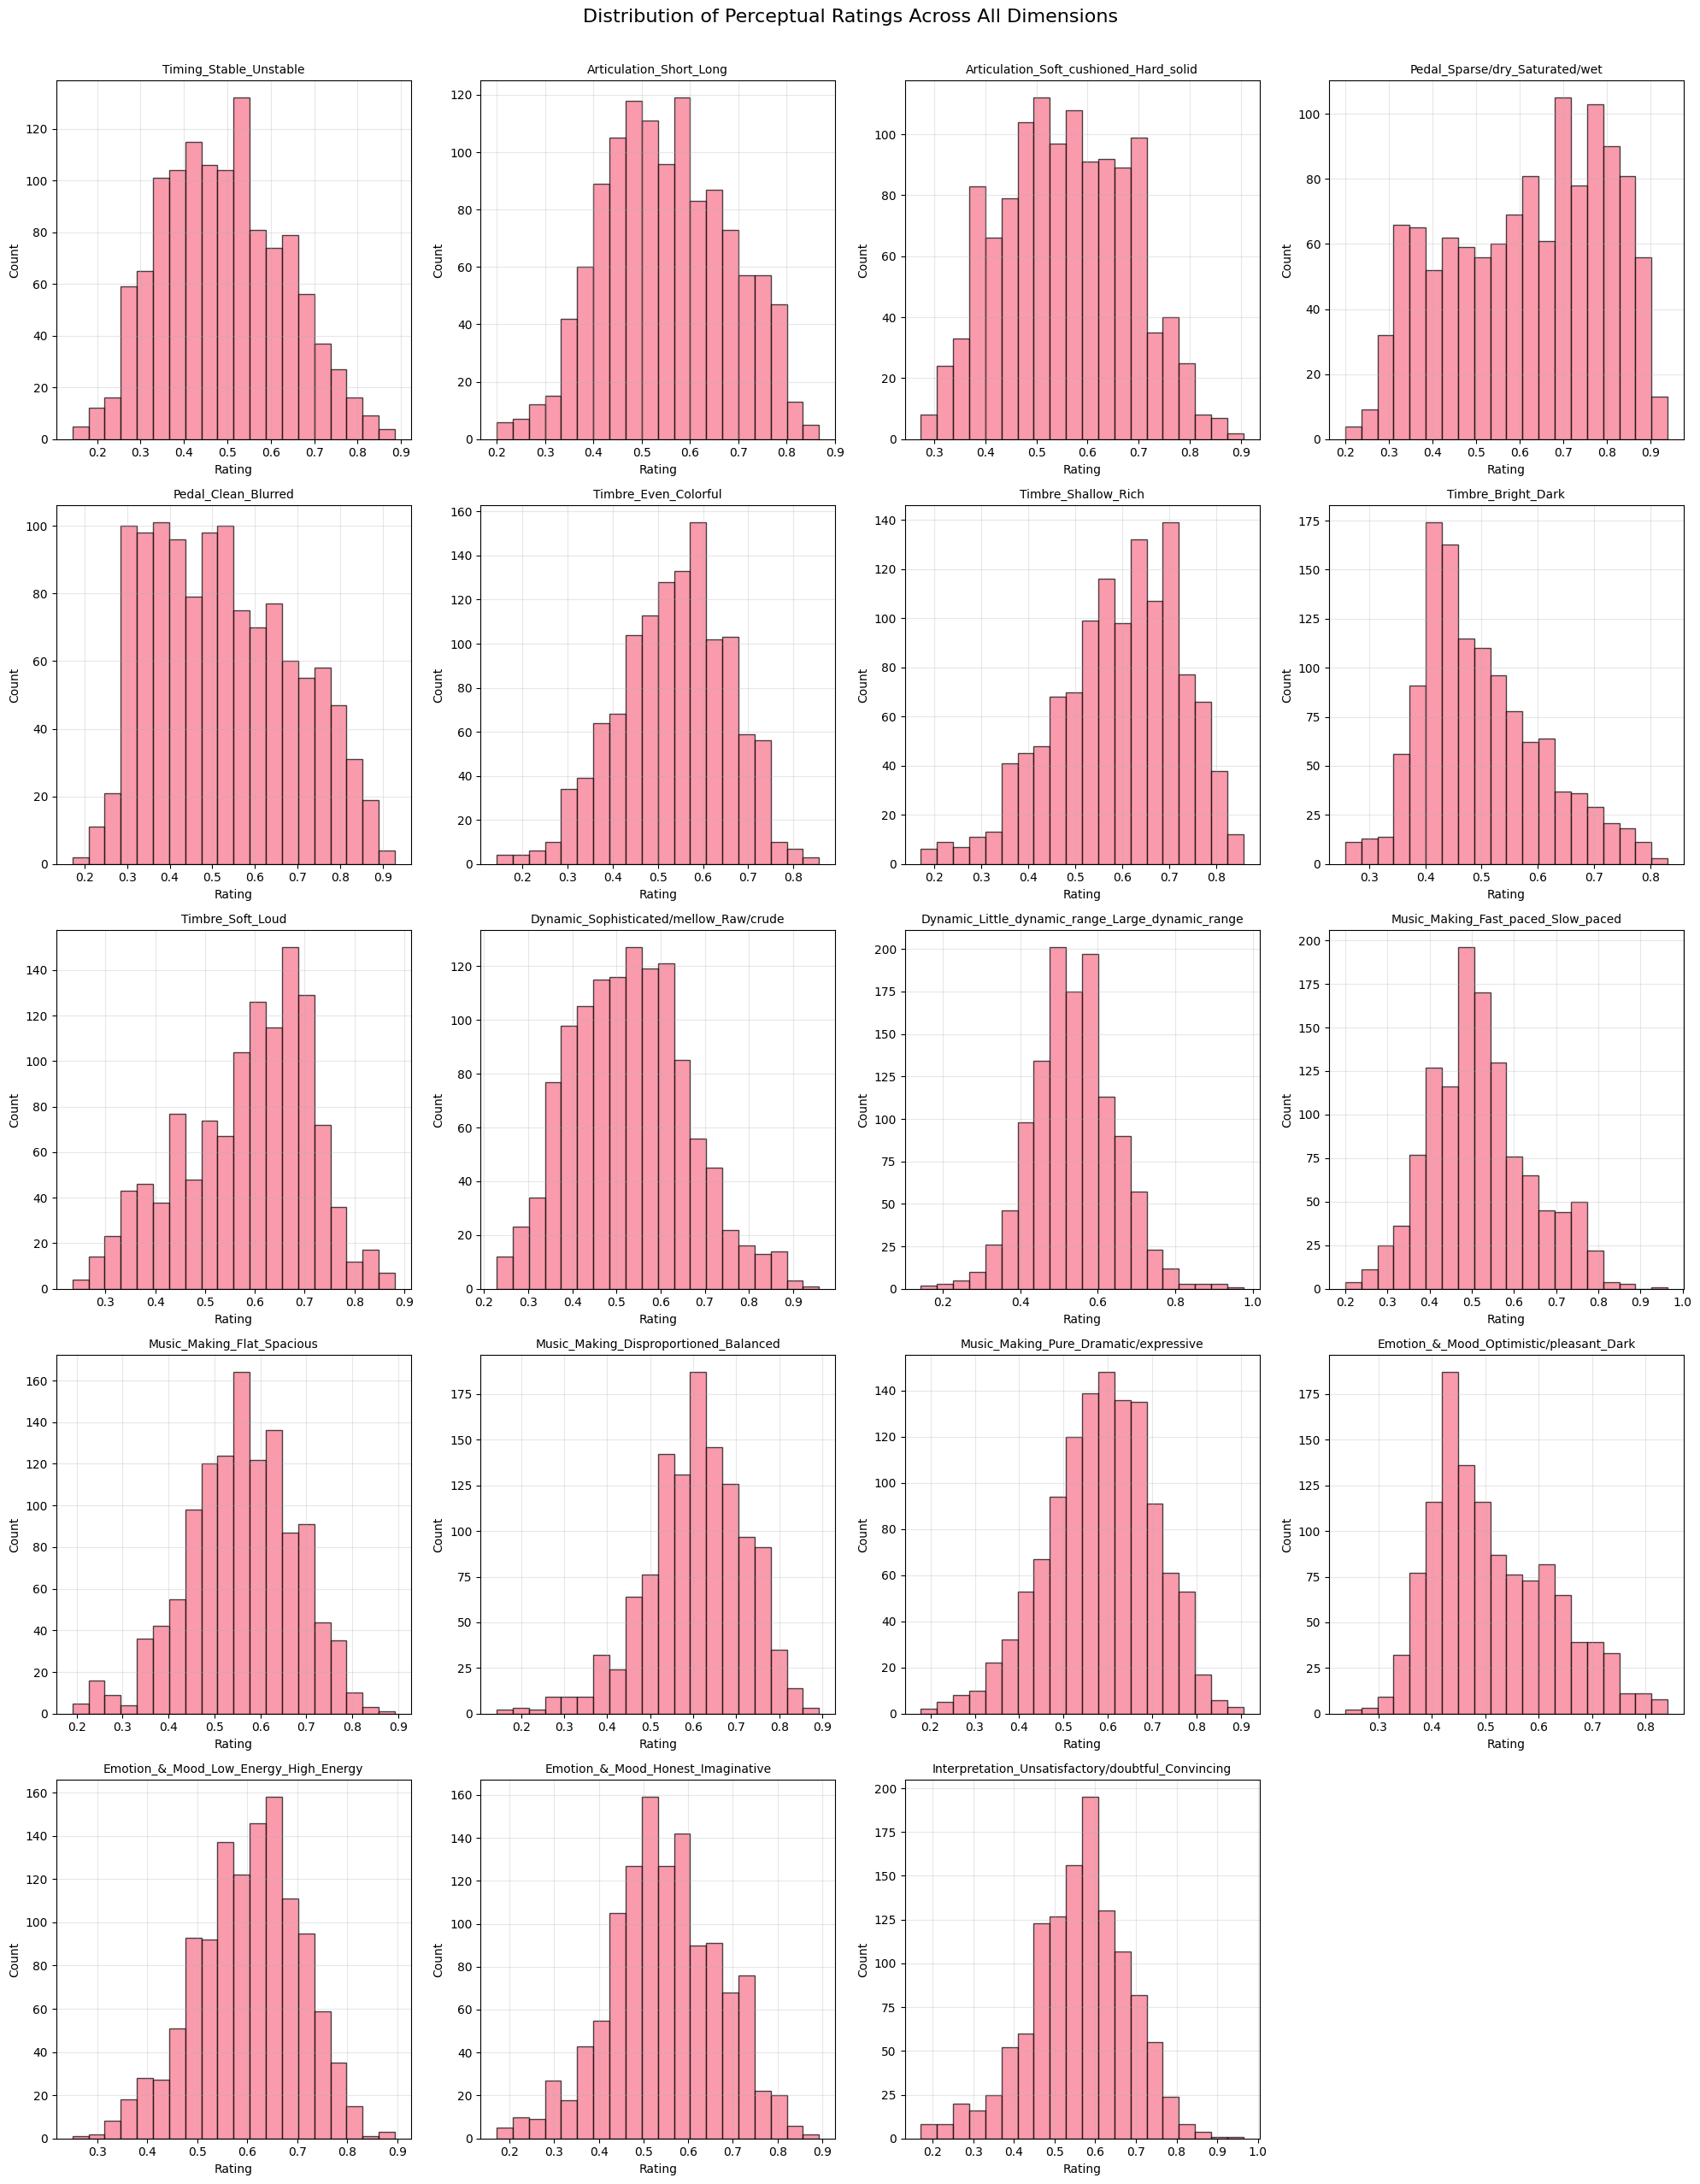

In [8]:
# Plot distribution of ratings for each dimension
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
axes = axes.flatten()

for i, dimension in enumerate(perceptual_dimensions):
    if i < len(axes):
        df[dimension].hist(bins=20, ax=axes[i], alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{dimension}', fontsize=10, wrap=True)
        axes[i].set_xlabel('Rating')
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(perceptual_dimensions), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Distribution of Perceptual Ratings Across All Dimensions', fontsize=16, y=1.02)
plt.show()

## 6. Correlation Analysis Between Perceptual Dimensions

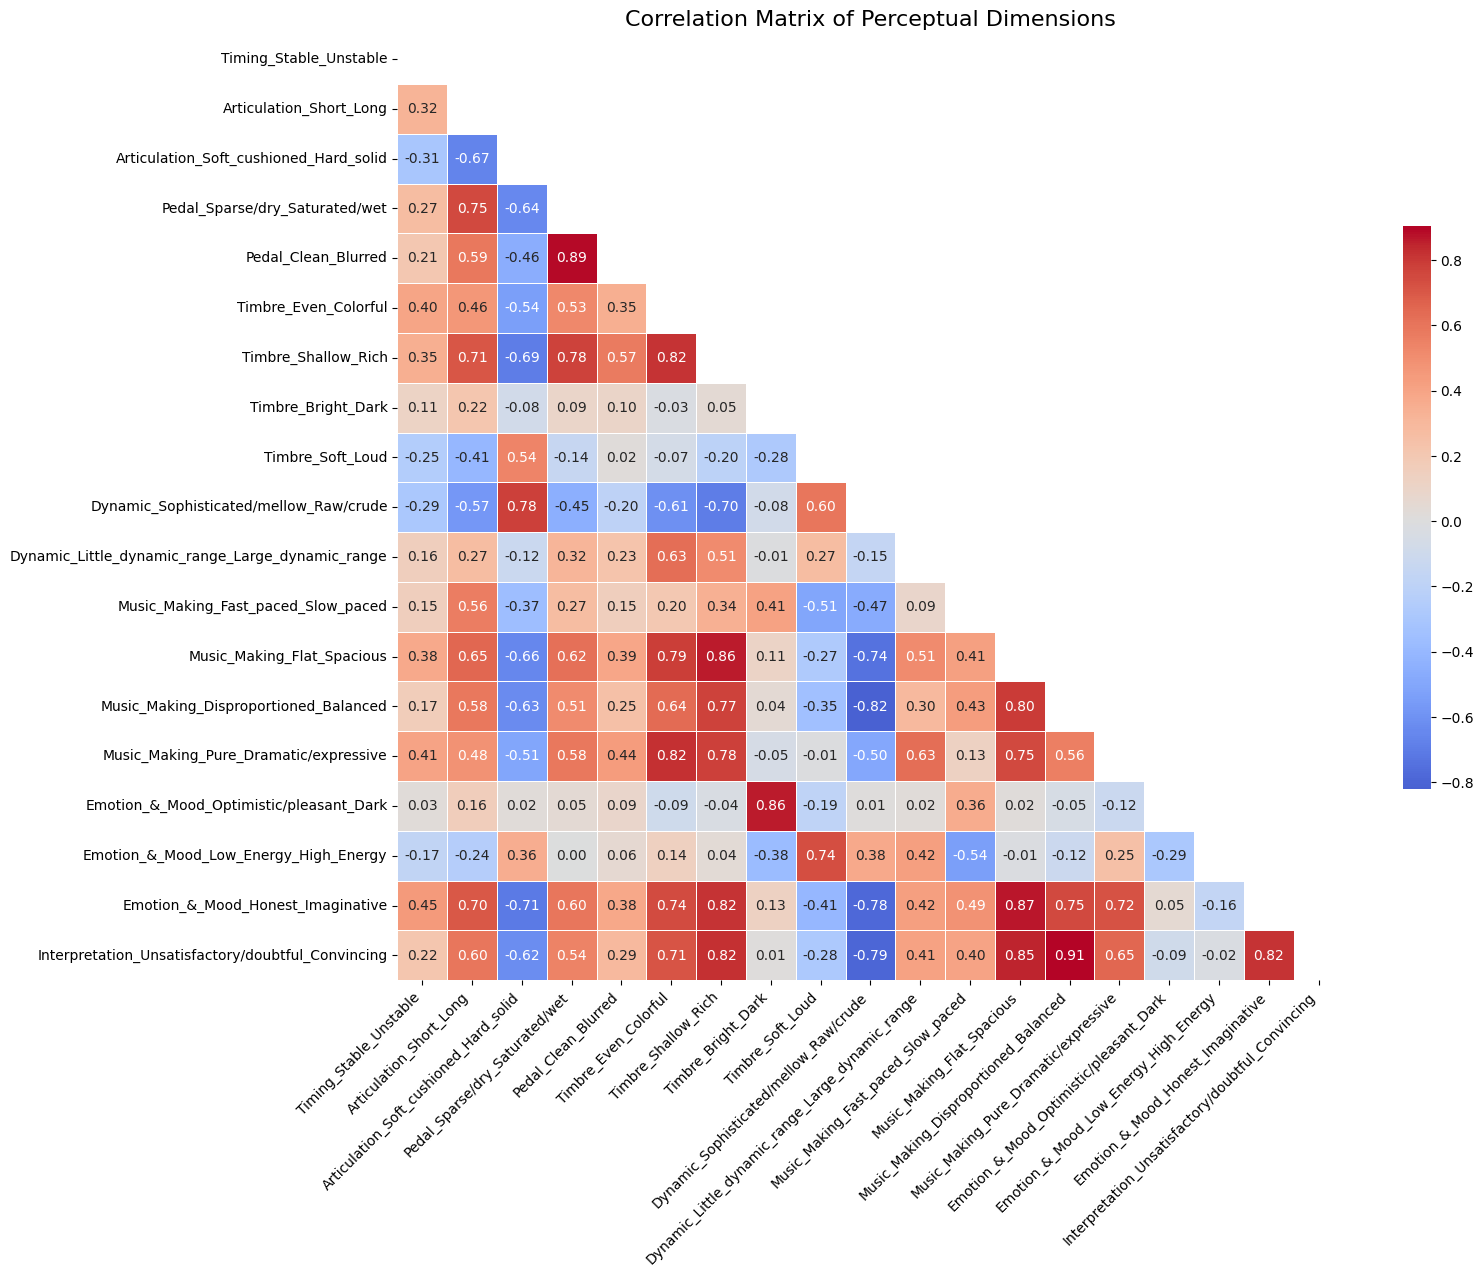


Strongest correlations (|r| > 0.5):
Music_Making_Disproportioned_Balanced <-> Interpretation_Unsatisfactory/doubtful_Convincing: 0.906
Pedal_Sparse/dry_Saturated/wet <-> Pedal_Clean_Blurred: 0.887
Music_Making_Flat_Spacious <-> Emotion_&_Mood_Honest_Imaginative: 0.871
Timbre_Shallow_Rich <-> Music_Making_Flat_Spacious: 0.862
Timbre_Bright_Dark <-> Emotion_&_Mood_Optimistic/pleasant_Dark: 0.860
Music_Making_Flat_Spacious <-> Interpretation_Unsatisfactory/doubtful_Convincing: 0.847
Timbre_Shallow_Rich <-> Interpretation_Unsatisfactory/doubtful_Convincing: 0.822
Dynamic_Sophisticated/mellow_Raw/crude <-> Music_Making_Disproportioned_Balanced: -0.820
Timbre_Even_Colorful <-> Music_Making_Pure_Dramatic/expressive: 0.820
Emotion_&_Mood_Honest_Imaginative <-> Interpretation_Unsatisfactory/doubtful_Convincing: 0.818


In [9]:
# Calculate correlation matrix
correlation_matrix = df[perceptual_dimensions].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.title('Correlation Matrix of Perceptual Dimensions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find strongest correlations
corr_pairs = []
for i in range(len(perceptual_dimensions)):
    for j in range(i+1, len(perceptual_dimensions)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Only strong correlations
            corr_pairs.append((perceptual_dimensions[i], perceptual_dimensions[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
print("\nStrongest correlations (|r| > 0.5):")
for dim1, dim2, corr in corr_pairs[:10]:
    print(f"{dim1} <-> {dim2}: {corr:.3f}")

## 7. Player Analysis

Number of unique players: 22
Player distribution:
player_id
0     99
1     99
2     17
3     77
4     17
5     17
6     77
7     94
8     17
9     94
10    77
11    30
12    13
13    17
14    17
15    81
16    17
17    81
18    64
19    69
20    64
21    64
Name: count, dtype: int64


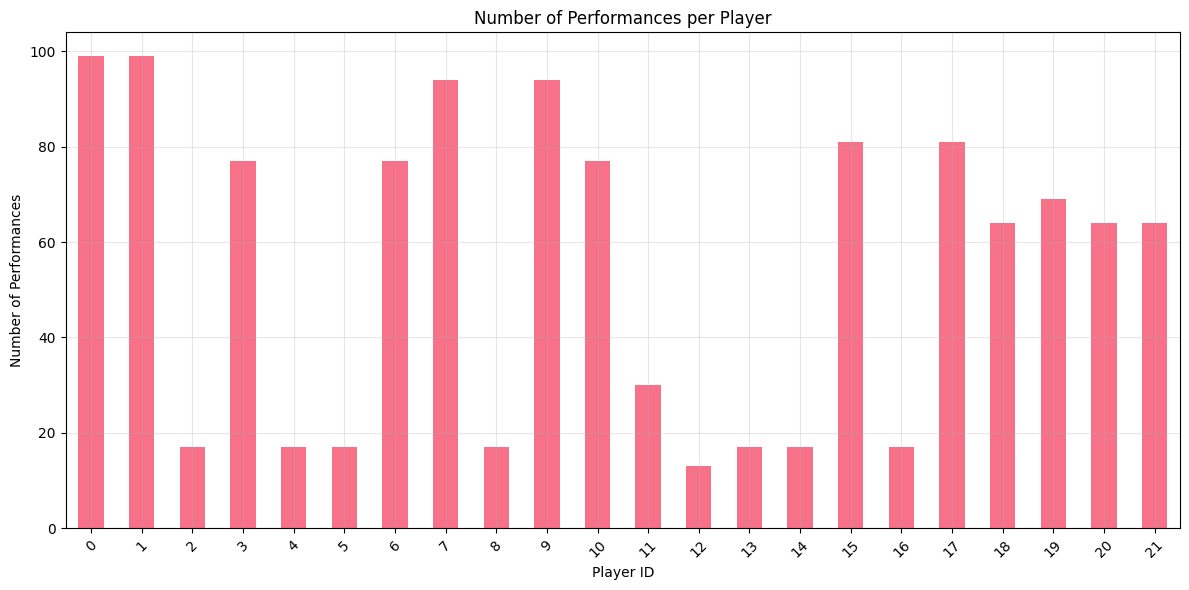

In [10]:
# Analyze player distribution
player_counts = df['player_id'].value_counts().sort_index()
print(f"Number of unique players: {len(player_counts)}")
print(f"Player distribution:")
print(player_counts)

# Plot player distribution
plt.figure(figsize=(12, 6))
player_counts.plot(kind='bar')
plt.title('Number of Performances per Player')
plt.xlabel('Player ID')
plt.ylabel('Number of Performances')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Example Audio Analysis

Let's examine the example audio file to understand the audio characteristics:

In [11]:
# Load and analyze example audio
if example_audio.exists():
    audio, sr = librosa.load(str(example_audio))
    print(f"Audio file: {example_audio.name}")
    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {len(audio)/sr:.2f} seconds")
    print(f"Audio shape: {audio.shape}")
    print(f"Audio range: [{audio.min():.3f}, {audio.max():.3f}]")
    
    # Get corresponding label for this performance
    perf_name = example_audio.stem  # Remove .wav extension
    if perf_name in labels_data:
        example_labels = labels_data[perf_name]
        print(f"\nCorresponding perceptual ratings:")
        for i, rating in enumerate(example_labels[:-1]):
            if i < len(perceptual_dimensions):
                print(f"{perceptual_dimensions[i]}: {rating:.3f}")
        print(f"Player ID: {example_labels[-1]}")
else:
    print("Example audio file not found")

Audio file: Beethoven_WoO80_var27_8bars_3_15.wav
Sample rate: 22050 Hz
Duration: 14.35 seconds
Audio shape: (316433,)
Audio range: [-0.523, 0.421]

Corresponding perceptual ratings:
Timing_Stable_Unstable: 0.343
Articulation_Short_Long: 0.314
Articulation_Soft_cushioned_Hard_solid: 0.743
Pedal_Sparse/dry_Saturated/wet: 0.457
Pedal_Clean_Blurred: 0.429
Timbre_Even_Colorful: 0.314
Timbre_Shallow_Rich: 0.371
Timbre_Bright_Dark: 0.600
Timbre_Soft_Loud: 0.800
Dynamic_Sophisticated/mellow_Raw/crude: 0.714
Dynamic_Little_dynamic_range_Large_dynamic_range: 0.371
Music_Making_Fast_paced_Slow_paced: 0.371
Music_Making_Flat_Spacious: 0.457
Music_Making_Disproportioned_Balanced: 0.543
Music_Making_Pure_Dramatic/expressive: 0.514
Emotion_&_Mood_Optimistic/pleasant_Dark: 0.714
Emotion_&_Mood_Low_Energy_High_Energy: 0.743
Emotion_&_Mood_Honest_Imaginative: 0.400
Interpretation_Unsatisfactory/doubtful_Convincing: 0.400
Player ID: 7


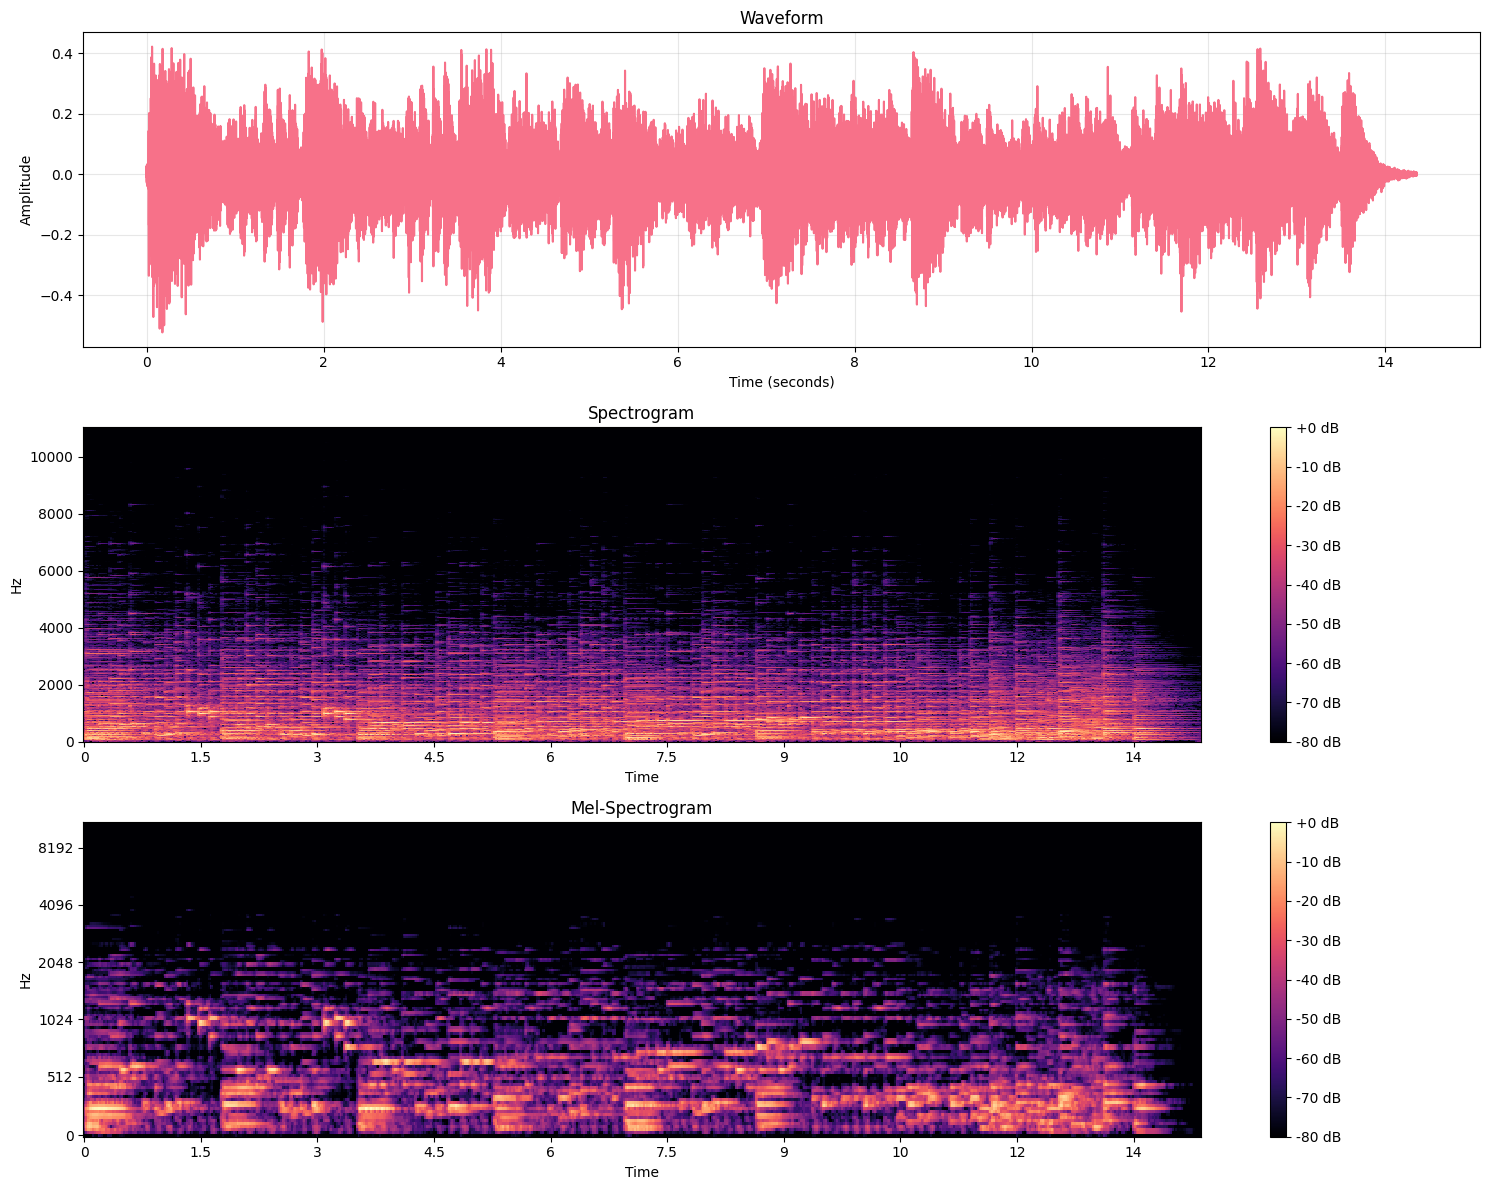

In [12]:
# Visualize the example audio
if example_audio.exists():
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Waveform
    times = np.linspace(0, len(audio)/sr, len(audio))
    axes[0].plot(times, audio)
    axes[0].set_title('Waveform')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Spectrogram
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    # Mel-spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    img2 = librosa.display.specshow(S_db_mel, sr=sr, x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title('Mel-Spectrogram')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

## 9. Key Insights and Next Steps

Based on this exploration, let's summarize key findings:

In [13]:
print("=== PercePiano Dataset Key Insights ===")
print(f"\n1. Dataset Size:")
print(f"   - Total performances: {len(labels_data)}")
print(f"   - Perceptual dimensions: {len(perceptual_dimensions)}")
print(f"   - Unique players: {len(df['player_id'].unique())}")

print(f"\n2. Perceptual Categories:")
for category, dims in categories.items():
    print(f"   - {category}: {len(dims)} dimensions")

print(f"\n3. Rating Characteristics:")
overall_mean = df[perceptual_dimensions].mean().mean()
overall_std = df[perceptual_dimensions].std().mean()
print(f"   - Overall mean rating: {overall_mean:.3f}")
print(f"   - Average std deviation: {overall_std:.3f}")
print(f"   - Rating range: [0, 1] (normalized)")

print(f"\n4. Strongest Correlations:")
for i, (dim1, dim2, corr) in enumerate(corr_pairs[:3]):
    print(f"   {i+1}. {dim1} <-> {dim2}: {corr:.3f}")

print(f"\n5. Musical Repertoire:")
print(f"   - Composers: {list(perf_df['composer'].value_counts().index)}")
print(f"   - Segment lengths: {list(perf_df['bars'].value_counts().index)}")

print(f"\n=== Next Steps for Phase 1 Implementation ===")
print(f"1. Set up audio processing pipeline with librosa")
print(f"2. Implement feature extraction (spectrograms, MFCCs, mel-spectrograms)")
print(f"3. Build PyTorch dataset class for PercePiano")
print(f"4. Start with single-dimension prediction model")
print(f"5. Progress to multi-task learning for all 19 dimensions")

=== PercePiano Dataset Key Insights ===

1. Dataset Size:
   - Total performances: 1202
   - Perceptual dimensions: 19
   - Unique players: 22

2. Perceptual Categories:
   - Timing: 1 dimensions
   - Articulation: 2 dimensions
   - Pedal: 2 dimensions
   - Timbre: 4 dimensions
   - Dynamic: 2 dimensions
   - Music: 4 dimensions
   - Emotion: 3 dimensions
   - Interpretation: 1 dimensions

3. Rating Characteristics:
   - Overall mean rating: 0.553
   - Average std deviation: 0.126
   - Rating range: [0, 1] (normalized)

4. Strongest Correlations:
   1. Music_Making_Disproportioned_Balanced <-> Interpretation_Unsatisfactory/doubtful_Convincing: 0.906
   2. Pedal_Sparse/dry_Saturated/wet <-> Pedal_Clean_Blurred: 0.887
   3. Music_Making_Flat_Spacious <-> Emotion_&_Mood_Honest_Imaginative: 0.871

5. Musical Repertoire:
   - Composers: ['Schubert', 'Beethoven']
   - Segment lengths: ['8bars', '16bars', '4bars']

=== Next Steps for Phase 1 Implementation ===
1. Set up audio processing pipel

## 10. Save Analysis Results

In [14]:
# Save processed data for future use (updated paths)
output_dir = base_path / 'results'
df.to_csv(output_dir / 'percepiano_labels_processed.csv', index=False)
correlation_matrix.to_csv(output_dir / 'percepiano_correlations.csv')

# Save key insights as JSON
insights = {
    'dataset_size': len(labels_data),
    'perceptual_dimensions': perceptual_dimensions,
    'categories': categories,
    'unique_players': int(len(df['player_id'].unique())),
    'composers': list(perf_df['composer'].value_counts().to_dict().keys()),
    'strongest_correlations': [(dim1, dim2, float(corr)) for dim1, dim2, corr in corr_pairs[:5]],
    'rating_stats': {
        'overall_mean': float(overall_mean),
        'overall_std': float(overall_std),
        'min_rating': float(df[perceptual_dimensions].min().min()),
        'max_rating': float(df[perceptual_dimensions].max().max())
    }
}

with open(output_dir / 'percepiano_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("Analysis results saved to results/ directory:")
print("- percepiano_labels_processed.csv")
print("- percepiano_correlations.csv") 
print("- percepiano_insights.json")

Analysis results saved to results/ directory:
- percepiano_labels_processed.csv
- percepiano_correlations.csv
- percepiano_insights.json
